In [ ]:
from pclab.datasets.modelnet import get_modelnet, ModelNet40
from pclab.transforms import *
from torch.utils.data import DataLoader
from pclab.models.pointnet import PointNetSeg
from pclab.utils import quick_vis

import torch
import torch.nn as nn
from functools import partial
import torch.optim as optim

import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import open3d as o3d

from miniai.learner import *
from miniai.sgd import *


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Dataset

In [ ]:
path = "/home/vvr/Desktop/vlassisgiannis/new_exps/data"
#train_dl, valid_dl = get_modelnet(path, batch_size=32)

transforms = [RandomPointKeep(1024), UnitSphereNormalization(), AnisotropicScale(), ToTensor()]
train_dataset = ModelNet40(path, 2048, 'train', transforms=transforms, category=0)
valid_dataset = ModelNet40(path, 2048, 'test' , transforms=transforms, category=0)

train_dl, valid_dl = map(partial(DataLoader, batch_size=32, shuffle=True, num_workers=8, drop_last=True), (train_dataset, valid_dataset))
print(len(train_dataset))

625


In [ ]:
batch = next(iter(train_dl))
print(batch[0].shape, batch[1].shape)
pc = batch[0]

torch.Size([32, 1024, 3]) torch.Size([32])


[<matplotlib.lines.Line2D>]

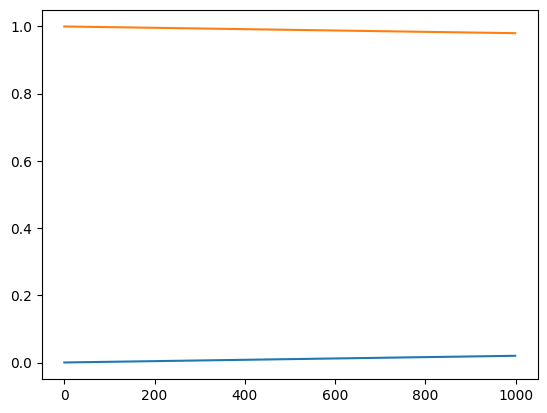

In [ ]:
beta_min, beta_max = 0.0001, 0.02
n_steps = 1000

beta = torch.linspace(beta_min, beta_max, n_steps)
alpha = 1 - beta

plt.plot(beta)
plt.plot(alpha)

[<matplotlib.lines.Line2D>]

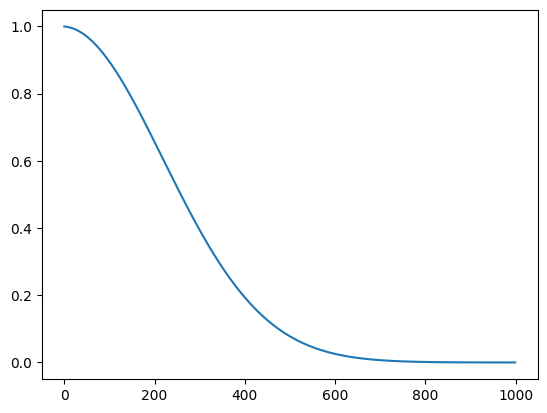

In [ ]:
alpha_hat = torch.cumprod(alpha, dim=0)
plt.plot(alpha_hat)

[<matplotlib.lines.Line2D>]

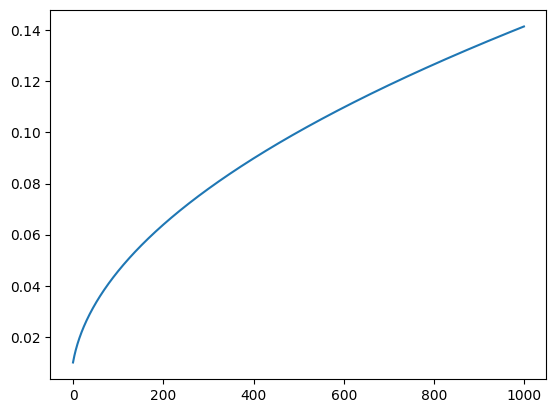

In [ ]:
sigma = beta.sqrt()
plt.plot(sigma)

In [ ]:
def euc2sph(pc):
    
    r = (pc * pc).sum(-1).sqrt()
    
    theta = torch.arccos(pc[..., 2] / r)
    
    fi = torch.sign(pc[..., 1]) * torch.arccos(  pc[..., 0] / (pc[..., 0:2] * pc[..., 0:2]).sum(-1).sqrt() )
    
    return r, theta , fi

def sph2euc(pc_shp):
    r, theta, fi = pc_shp
    
    x = r * torch.sin(theta) * torch.cos(fi)
    y = r * torch.sin(theta) * torch.sin(fi)
    z = r * torch.cos(theta)
        
    return torch.cat([r for r in map(partial(torch.unsqueeze, dim=-1), (x, y, z))], dim=-1)

In [ ]:
quick_vis(pc[0])
pc_sph = euc2sph(pc)
r, theta , fi = pc_sph

pc_back = sph2euc(pc_sph)
#quick_vis(pc_back[0])

In [ ]:
def plot_sph_dist(pc_sph):
    
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 3, 1)
    plt.hist(r.view(-1), bins=100)
    plt.title('r')

    plt.subplot(1, 3, 2)
    plt.hist(theta.view(-1) / torch.pi * 180, bins=100)
    plt.title('theta')

    plt.subplot(1, 3, 3)
    plt.hist(fi.view(-1) / torch.pi * 180, bins=100)
    plt.title('fi')
    
    plt.show()

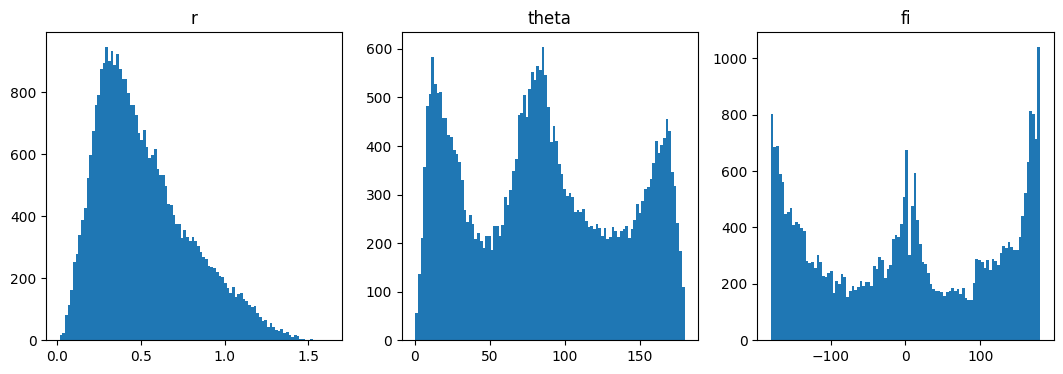

In [ ]:
plot_sph_dist(pc_sph)

In [ ]:
noise = torch.randn(pc.shape)
#quick_vis(noise[0])
print(noise.shape)

torch.Size([32, 1024, 3])


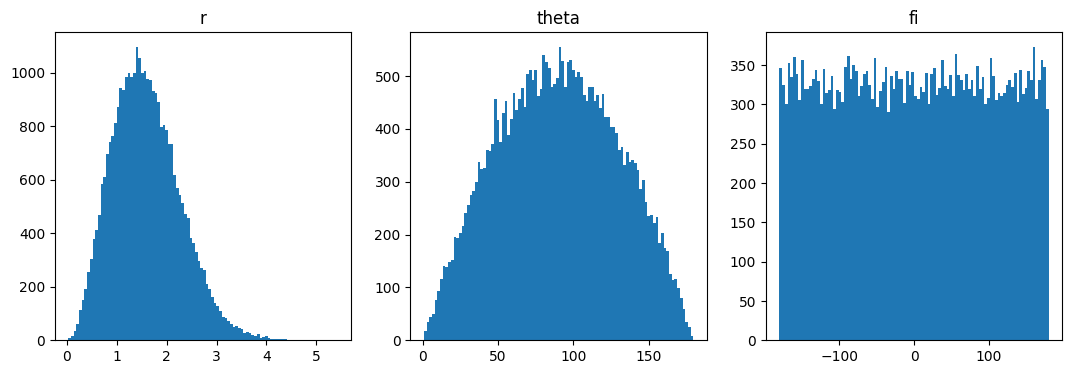

In [ ]:
noise_sph = euc2sph(noise)
r, theta, fi = noise_sph
plot_sph_dist(noise_sph)

We notice that the angles of the noise generated with the gaussian distribution have the desired distributions. 
The magnitude of the noise is however 3 times larger than the amplitude of the signal. 

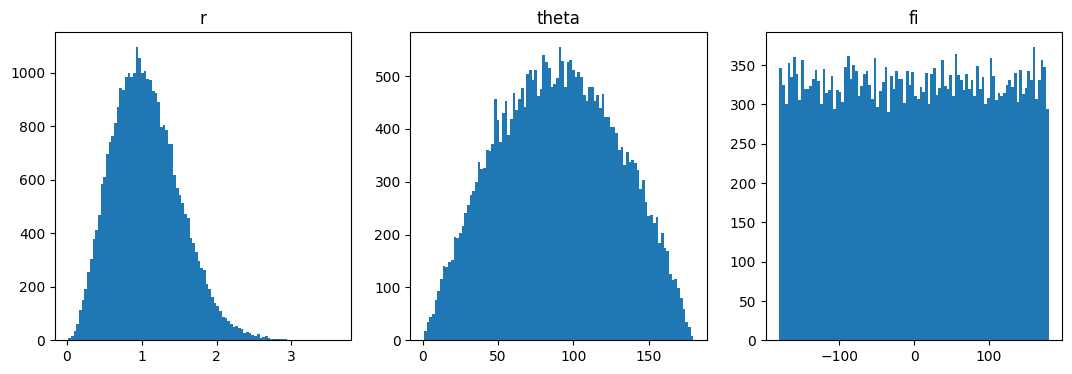

In [ ]:
r = r / 1.500
noise_sph = (r, theta, fi)
plot_sph_dist(noise_sph)

In [ ]:
# turn the noise back to euclidean space to add it to the point cloud
noise = sph2euc(noise_sph)
#quick_vis(noise[0])

In [ ]:
noisy_model = noise + pc
quick_vis(noisy_model[0])

### Creating the noise for each step - before batch

In [ ]:
scale_factor = 1 #1/1.5

In [ ]:
# noise 
noise = scale_factor * torch.randn(batch[0].shape)
# original sample
x0 = batch[0]

In [ ]:
# select a random timestep
t = torch.randint(0, n_steps, (x0.shape[0], ), dtype=torch.long)
#t

In [ ]:
alpha_hat_t = alpha_hat[t].reshape(-1, 1, 1)
#alpha_hat_t

In [ ]:
xt = alpha_hat_t.sqrt() * x0 + (1 - alpha_hat_t.sqrt()).sqrt() * noise 

In [ ]:
#quick_vis(xt[0])

In [ ]:
#quick_vis(xt[1])

In [ ]:
#quick_vis(batch[0][1])

In [ ]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): 
        learn.preds = learn.model(learn.batch[0][0].permute(0, 2, 1))
    
    def before_batch(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε #noisify the image
        # input to our model is noisy image and timestep, ground truth is the noise 
        learn.batch = ((xt, t), ε)
    
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learn.model(x_t.permute(0, 2, 1))
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

In [ ]:
class loader_bundle:
    pass
dls = loader_bundle
dls.train = train_dl
dls.test  = valid_dl
dls.valid = dls.test

In [ ]:
model = PointNetSeg()

In [ ]:
lr = 0.001 #4e-3
epochs = 2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

loss,epoch,train
0.561,0,train
0.909,0,eval
0.560,1,train
0.570,1,eval


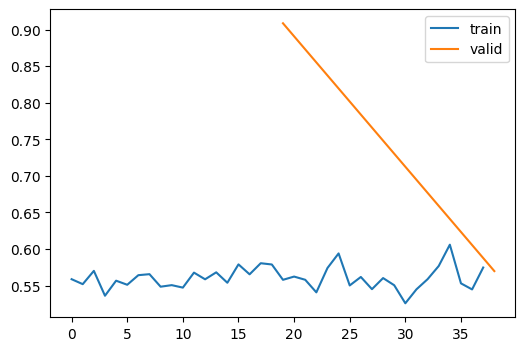

In [ ]:
learn.fit(epochs)

In [ ]:
samples = ddpm_cb.sample(learn.model, (2, 1024, 3))

In [ ]:
samples[0].shape

torch.Size([2, 1024, 3])

In [ ]:
last = samples[999][1].cpu()
quick_vis(last)

In [ ]:
samples[999][1].max(), samples[999][1].min()

(tensor(0.9332), tensor(-1.))

In [ ]:
samples[999][1][..., 0].max(), samples[999][1][..., 1].max(), samples[999][1][..., 2].max()

(tensor(0.7952), tensor(0.8323), tensor(0.9332))

In [ ]:
samples[999][1][..., 0].min(), samples[999][1][..., 1].min(), samples[999][1][..., 2].min()

(tensor(-1.), tensor(-1.), tensor(-1.))

### Loss Functions - Is mse working? 